In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer los archivos CSV
train_data = pd.read_csv("DailyDelhiClimateTrain.csv")
test_data = pd.read_csv("DailyDelhiClimateTest.csv")

# Mostrar las primeras filas para verificar la carga
print("Datos de entrenamiento:")
print(train_data.head())
print("\nDatos de prueba:")
print(test_data.head())

# Combinar datos
full_data = pd.concat([train_data, test_data], ignore_index=True)
print("\nDatos combinados:")
print(full_data.head())
print("\nColumnas y tipos de datos:")
print(full_data.info())

print("\nEstadísticas descriptivas:")
print(full_data.describe())

# Convertir la columna "date" a tipo datetime
full_data["date"] = pd.to_datetime(full_data["date"])

# Variables para graficar (opcional, igual que antes)
dates = pd.to_datetime(full_data["date"])  # Convertir a formato de fechas
mean_temp = full_data["meantemp"]
humidity = full_data["humidity"]
wind_speed = full_data["wind_speed"]
mean_pressure = full_data["meanpressure"]

# --- Gráficas iniciales (igual que tu código) ---
# ... (subplots, etc.) ...

# Filtrar datos antes de 2016 (si quieres mantener esa gráfica)
filtered_data = full_data[pd.to_datetime(full_data["date"]) < "2016-01-01"].copy()
filtered_data["date"] = pd.to_datetime(filtered_data["date"])

# --- Gráfica de presión antes de 2016 (opcional) ---
# ... (plot) ...

# Crear columnas de año y mes
full_data["year"] = full_data["date"].dt.year
full_data["month"] = full_data["date"].dt.month

# Agrupar por año y mes, y calcular promedios
monthly_data = full_data.groupby(["year", "month"]).agg({
    "meantemp": "mean",
    "humidity": "mean",
    "wind_speed": "mean",
    "meanpressure": "mean"
}).reset_index()

# Crear una columna de fecha continua para graficar y modelar
monthly_data["date"] = monthly_data["year"] + (monthly_data["month"] - 1) / 12

print(monthly_data.head())

# Seleccionar las características y la columna de fechas
features = ["meantemp", "humidity", "wind_speed", "meanpressure"]
dates = monthly_data["date"].to_numpy()
values = monthly_data[features].to_numpy()

# Normalizar las fechas para que comiencen en 0
t = dates - dates.min()

# Normalizar las características (media 0, desviación estándar 1)
mean_vals = values.mean(axis=0)
std_vals = values.std(axis=0)
y = (values - mean_vals) / std_vals

# Dividir en conjuntos de entrenamiento y prueba
T = 20  # Número de observaciones para el conjunto de entrenamiento
train_t, test_t = t[:T], t[T:]
train_y_raw, test_y_raw = y[:T], y[T:]

# Para la LSTM, necesitamos tensores, pero también ajustaremos la forma
import torch

train_t_tensor = torch.tensor(train_t, dtype=torch.float32)
test_t_tensor  = torch.tensor(test_t, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_raw, dtype=torch.float32)  # (T, input_dim)
test_y_tensor  = torch.tensor(test_y_raw, dtype=torch.float32)


Datos de entrenamiento:
         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

Datos de prueba:
         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333

Datos combinados:
         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-0

In [2]:
def create_sequences(data_tensor, seq_length=1):
    """
    Crea pares (X, Y) para entrenamiento de una LSTM en predicción un-paso.
    X: secuencia de entrada (batch, seq_len, features)
    Y: siguiente valor (batch, features)
    """
    X_list = []
    Y_list = []
    for i in range(len(data_tensor) - seq_length):
        # Del índice i hasta i+seq_length-1 -> input
        X_list.append(data_tensor[i : i+seq_length])
        # La etiqueta es el valor en i+seq_length
        Y_list.append(data_tensor[i+seq_length])
    
    X = torch.stack(X_list)  # shape: (num_samples, seq_length, features)
    Y = torch.stack(Y_list)  # shape: (num_samples, features)
    return X, Y

seq_length = 1  # Para ejemplo simple: un paso (puedes usar más)
train_X, train_Y = create_sequences(train_y_tensor, seq_length)
test_X,  test_Y  = create_sequences(test_y_tensor, seq_length)

print("Train shapes:", train_X.shape, train_Y.shape)
print("Test shapes:", test_X.shape, test_Y.shape)


Train shapes: torch.Size([19, 1, 4]) torch.Size([19, 4])
Test shapes: torch.Size([31, 1, 4]) torch.Size([31, 4])


In [3]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        """
        # Estado inicial oculto y de celda en cero, para simplificar
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

        # Salida de la LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # out: (batch, seq_len, hidden_dim)

        # Tomamos la última salida de la secuencia
        out_last = out[:, -1, :]  # (batch, hidden_dim)

        # Pasamos por la capa fully-connected
        y_pred = self.fc(out_last)  # (batch, input_dim)

        return y_pred


In [4]:
from torch.optim import AdamW

def train_one_round(model, X_subset, Y_subset, optimizer, max_iters=150):
    criterion = nn.MSELoss()
    model.train()
    for _ in range(max_iters):
        optimizer.zero_grad()
        y_pred = model(X_subset)
        loss = criterion(y_pred, Y_subset)
        loss.backward()
        optimizer.step()
    return loss.item()

def train_lstm_incremental(train_y_tensor, seq_length=1, lr=1e-3, max_iters=150):
    """
    Entrena el modelo LSTM de forma incremental, usando bloques de 4 muestras en cada paso,
    similar a lo que hacías con Neural ODE.
    """
    input_dim = train_y_tensor.shape[1]  # 4 en nuestro caso
    model = LSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=1)
    optimizer = AdamW(model.parameters(), lr=lr)

    losses = []
    num_obs = range(4, len(train_y_tensor)+1, 4)  # de 4 en 4

    for k in num_obs:
        # Creamos secuencias hasta k
        subset = train_y_tensor[:k]
        X_sub, Y_sub = create_sequences(subset, seq_length)

        # Entrenamos una ronda
        loss = train_one_round(model, X_sub, Y_sub, optimizer, max_iters)
        losses.append(loss)

    return model, losses

# Entrenamos de forma incremental
model, losses = train_lstm_incremental(train_y_tensor, seq_length=seq_length, lr=1e-3, max_iters=150)
print("Pérdidas en cada etapa:", losses)


Pérdidas en cada etapa: [0.01686306856572628, 0.11530471593141556, 0.15941467881202698, 0.11100216954946518, 0.12513543665409088]


In [5]:
def predict_lstm(model, data_tensor, seq_length=1):
    """
    Predice secuencialmente un paso hacia adelante en todo el dataset.
    data_tensor: (N, input_dim)
    return: predicciones (N-seq_length, input_dim)
    """
    model.eval()
    X_seq, Y_seq = create_sequences(data_tensor, seq_length=seq_length)
    with torch.no_grad():
        y_pred = model(X_seq)
    return y_pred  # (N-seq_length, input_dim)

# Predicción en entrenamiento
train_y_pred_tensor = predict_lstm(model, train_y_tensor, seq_length)
# Predicción en prueba
test_y_pred_tensor  = predict_lstm(model, test_y_tensor, seq_length)

print("Shape predicciones entrenamiento:", train_y_pred_tensor.shape)
print("Shape predicciones prueba:", test_y_pred_tensor.shape)


Shape predicciones entrenamiento: torch.Size([19, 4])
Shape predicciones prueba: torch.Size([31, 4])


In [6]:
def denormalize(data_norm, mean_vals, std_vals):
    return data_norm * std_vals + mean_vals

train_y_pred = train_y_pred_tensor.numpy()
test_y_pred  = test_y_pred_tensor.numpy()

# Para comparar, ajustamos las dimensiones de train_y_raw y test_y_raw:
# - train_y_pred tiene longitud T-1 (19)
# - train_y_raw tenía longitud T (20)
# Para alinear, ignoramos el primer punto en train_y_raw al graficar.
train_y_raw_plot = train_y_raw[seq_length:]  # (19, 4)
test_y_raw_plot  = test_y_raw[seq_length:]   # (len(test)-1, 4)

# Desnormalizamos
train_y_pred_den = denormalize(train_y_pred, mean_vals, std_vals)
train_y_raw_den  = denormalize(train_y_raw_plot, mean_vals, std_vals)

test_y_pred_den  = denormalize(test_y_pred,  mean_vals, std_vals)
test_y_raw_den   = denormalize(test_y_raw_plot,  mean_vals, std_vals)


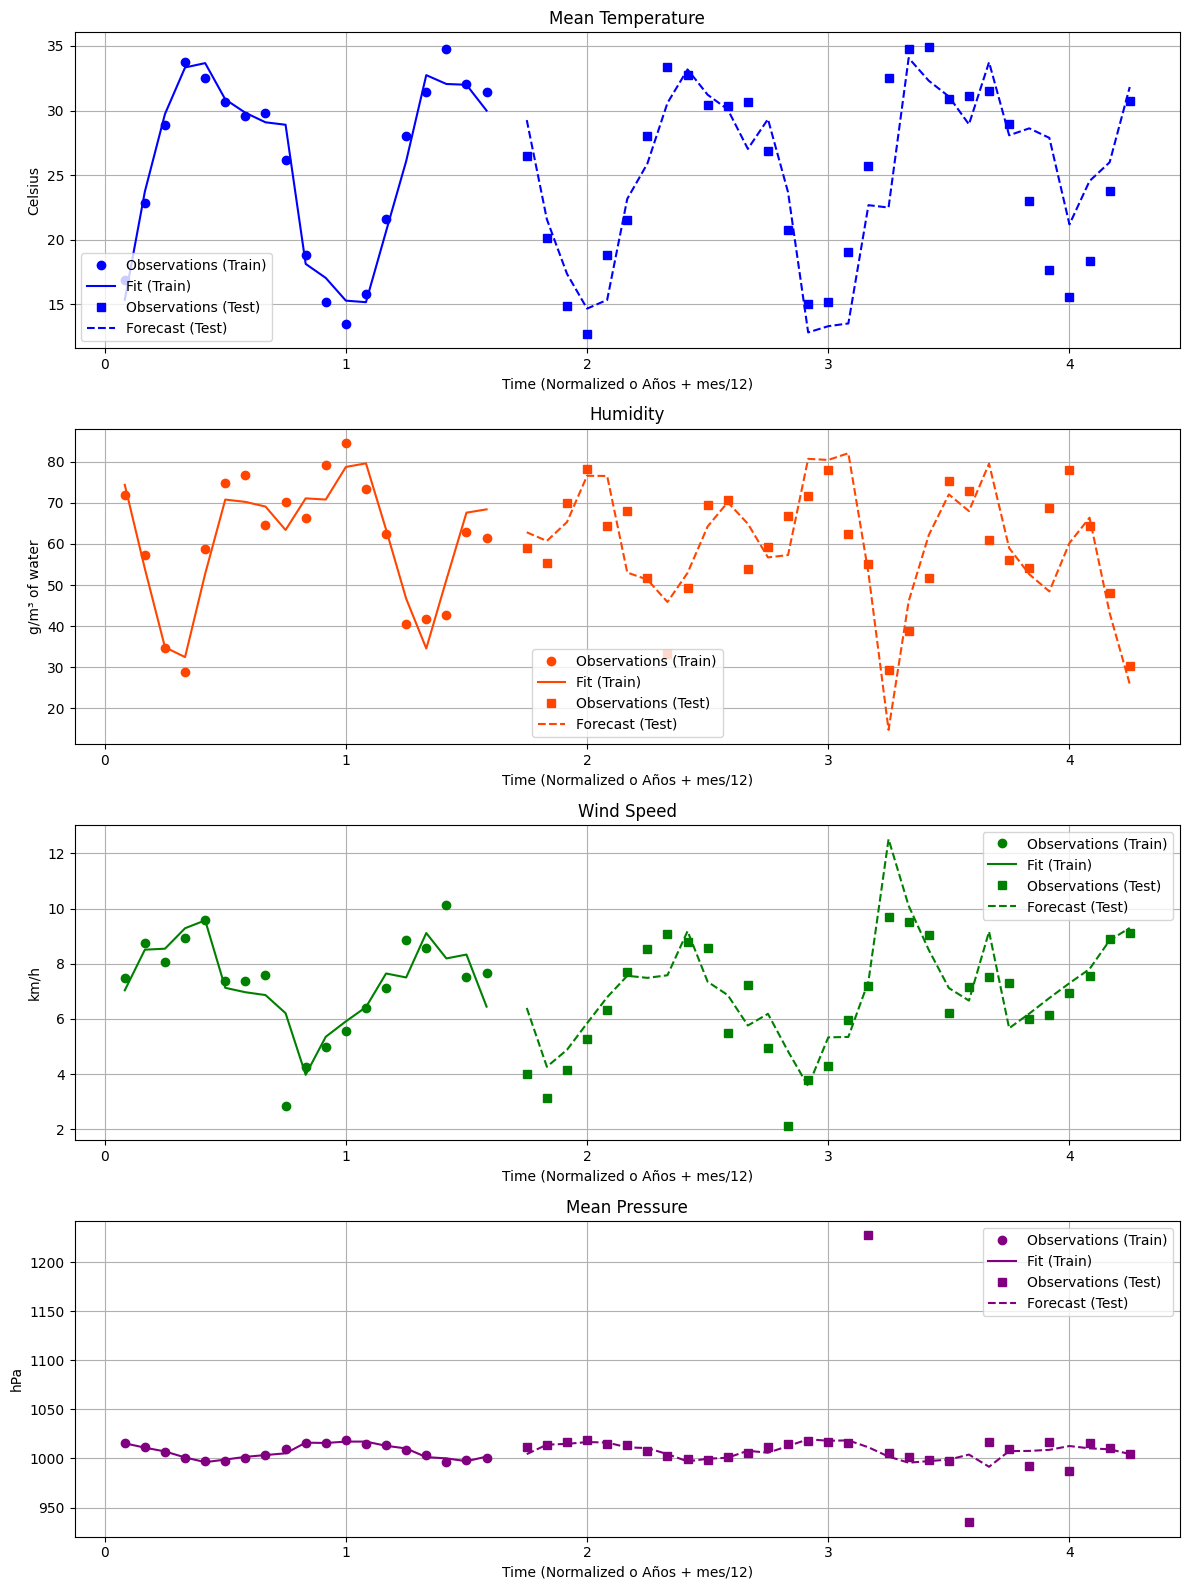

In [7]:
features_names = ["Mean Temperature", "Humidity", "Wind Speed", "Mean Pressure"]
colors = ["blue", "#FF4500", "green", "purple"]
units = ["Celsius", "g/m³ of water", "km/h", "hPa"]

# Ajustamos ejes de tiempo para entrenamiento y prueba
train_t_plot = train_t[seq_length:]  # si seq_length=1, hay 19 puntos
test_t_plot  = test_t[seq_length:]

fig, axs = plt.subplots(4, 1, figsize=(12, 16))
for i, ax in enumerate(axs):
    # Observaciones en entrenamiento
    ax.plot(train_t_plot, train_y_raw_den[:, i], 'o', color=colors[i], label='Observations (Train)')
    # Predicciones en entrenamiento
    ax.plot(train_t_plot, train_y_pred_den[:, i], '-', color=colors[i], label='Fit (Train)')

    # Observaciones en prueba
    ax.plot(test_t_plot, test_y_raw_den[:, i], 's', color=colors[i], label='Observations (Test)')
    # Predicciones en prueba
    ax.plot(test_t_plot, test_y_pred_den[:, i], '--', color=colors[i], label='Forecast (Test)')

    ax.set_title(features_names[i])
    ax.set_xlabel("Time (Normalized o Años + mes/12)")
    ax.set_ylabel(units[i])
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()
